In [352]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import missingno as msno
import warnings 
warnings.filterwarnings("ignore")

<h1>NİTELİKLİ KAÇAK TAHMİNLEME</h1>

In [353]:
full_table = pd.read_excel('train_5.xlsx')
full_table.head()

,TUKETIM_M1,TUKETIM_M2,TUKETIM_M3,TUKETIM_M4,TUKETIM_M5,TUKETIM_M6,TUKETIM_M7,TUKETIM_M8,TUKETIM_M9,TUKETIM_M10,...,SAYAC_BASLANGIC_TARIHI,SAYAC_BITIS_TARIHI,SAYAC_MARKA,SAYAC_MODEL,SAYAC_MALZEME_ID,SAYAC_OLCUM_TURU,SAYAC_FAZ_N,SAYAC_TAKILMA_TARIHI,SAYAC_YAPIM_YILI,NK_FLAG
0,54.067286,260.483048,275.618048,273.467499,281.655063,352.713057,415.387382,506.970118,536.242000,497.518271,...,2016-10-18,9999-12-31 00:00:00,LUNA,LUN1,80000107.0,Aktif,Monofaze,2016-10-18,2012.0,0
1,125.413387,227.864889,253.651891,230.289027,241.382306,248.334700,217.821800,249.203886,246.356225,203.709124,...,2016-09-25,9999-12-31 00:00:00,ELEKTROMED,EC058MBW,80000731.0,Aktif,Monofaze,2016-09-25,2015.0,0
2,308.273107,386.164464,392.016065,238.200398,163.968966,162.782897,187.088937,212.920402,204.618086,181.509614,...,2016-10-11,9999-12-31 00:00:00,ELEKTROMED,EC15ATBW,80000732.0,Aktif,Trifaze,2016-10-11,2016.0,0
3,23.105143,49.197286,64.653696,73.807875,31.418710,31.834563,24.261624,27.079161,26.952110,32.072690,...,2016-05-24,9999-12-31 00:00:00,LUNA,LUN10,80000710.0,Aktif,Monofaze,2016-05-24,2016.0,0
4,36.016793,48.795995,50.209868,50.969201,49.746943,89.461700,328.368786,469.163521,432.848994,461.588897,...,2018-05-30,9999-12-31 00:00:00,LUNA,LUN10-B,80001006.0,Aktif,Monofaze,2018-05-30,2017.0,0


<h2>EDA - Exploratory Data Analysis (Veri Keşfi)</h2>

In [354]:
full_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 50 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   TUKETIM_M1              15000 non-null  float64       
 1   TUKETIM_M2              15000 non-null  float64       
 2   TUKETIM_M3              15000 non-null  float64       
 3   TUKETIM_M4              15000 non-null  float64       
 4   TUKETIM_M5              15000 non-null  float64       
 5   TUKETIM_M6              15000 non-null  float64       
 6   TUKETIM_M7              15000 non-null  float64       
 7   TUKETIM_M8              15000 non-null  float64       
 8   TUKETIM_M9              15000 non-null  float64       
 9   TUKETIM_M10             15000 non-null  float64       
 10  TUKETIM_M11             15000 non-null  float64       
 11  TUKETIM_M12             15000 non-null  float64       
 12  TUKETIM_M13             14956 non-null  float6

<h3>Target</h3>
Amacımız geçmişte tesisatta kaçak olup olmadığı verileri üzerinden kaçak tespiti yapmak ve buradaki hedefimiz olan veri ise <b>'NK_FLAG'</b>. Tüm bu projenin sonucunda tahmin edeceğimiz veriye dair elimizde neler olduğuna bir bakalım.

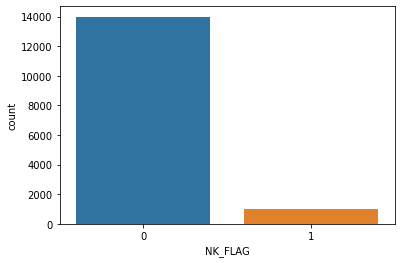

In [355]:
sns.countplot(full_table['NK_FLAG']);

In [356]:
print('Value Counts Normalize False')
print(full_table.NK_FLAG.value_counts())

print('-'*75)

print('Value Counts Normalize True')
print(full_table.NK_FLAG.value_counts(normalize=True))

Value Counts Normalize False
0    13980
1     1020
Name: NK_FLAG, dtype: int64
---------------------------------------------------------------------------
Value Counts Normalize True
0    0.932
1    0.068
Name: NK_FLAG, dtype: float64


İlk bakışta tahminleyeceğimiz veriler arasında ciddi bir dengesizlik olduğunu görüyoruz. 0'a ait veriler veri setinde 1'e ait verilere göre on dört kat daha fazla yer almaktadır. İlerde ciddi bir oversampling ya da undersampling işlemi bizi bekliyor diyebiliriz. Peki verilerimizin hedef verimiz ile ilişkileri nasıl? Her biri için ayrı ayrı inceleyelim fakat bunun için öncelikle kategorik ve nümerik verileri ayıralım.

<h3>Features</h3>

<h4>Kategorik ve Nümerik verilerin ayrıştırılması<h4>

In [357]:
cat_values = [i for i in full_table if full_table[i].dtype == 'object']
num_values = [k for k in full_table if full_table[k].dtype == 'float64']
cat_values, num_values = full_table[cat_values], full_table[num_values]

Kategorik veriler ile nümerik verileri yukarıda ayrıştırdık. Nümerik verilerin bir tanesi hariç hepsi <b>float64</b> tipinde olduğu için kontrole sadece o eklendi. Bir adet <b>int64</b> değişkenimiz var o da target verisi, bundan ötürü nümerik değişkenlerimiz içerisine almadık. O zaman şimdi değişkenlerimizi biraz daha yakından tanıyalım.
<h4>Nümerik verilerin ilişkileri</h4>

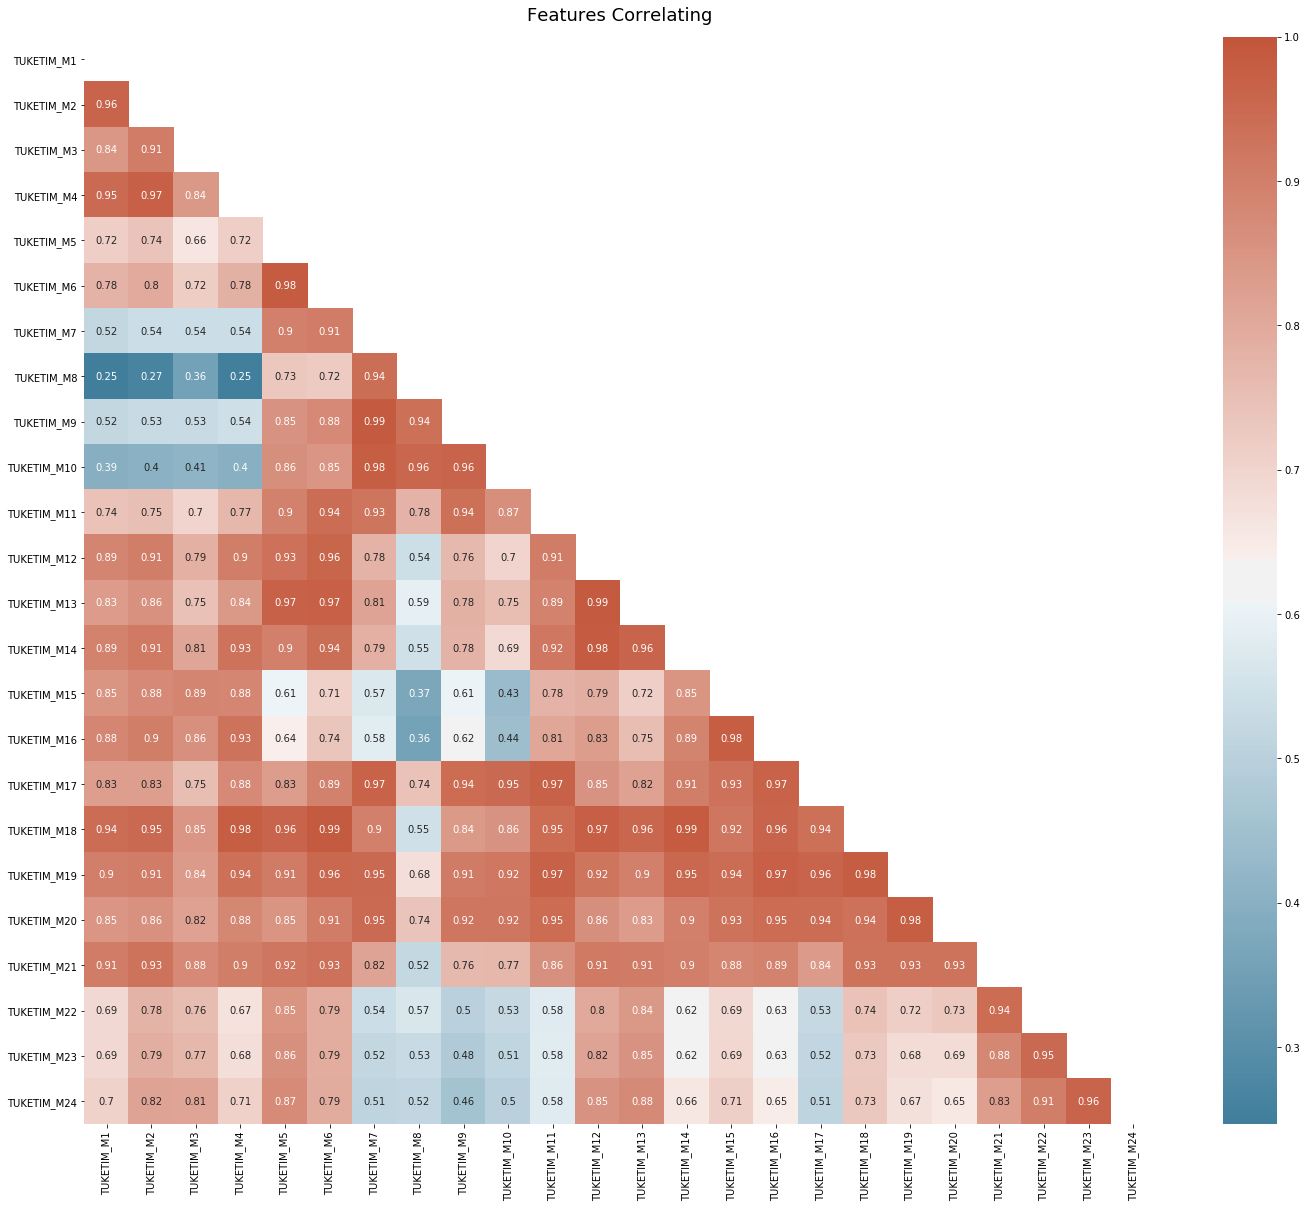

In [358]:
num_values1 = num_values.iloc[:,:24]

corr = num_values1.corr()

f, ax = plt.subplots(figsize=(24, 20))

mask = np.triu(np.ones_like(corr, dtype=bool))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

heatmap = sns.heatmap(corr, annot=True, mask = mask, cmap=cmap);
heatmap.set_title('Features Correlating', fontdict={'fontsize':18}, pad=16);

<br>
Tüketim miktarları arasındaki korelasyon değerleri incelendiğinde birbirini takip eden zamanlar içerisinde genel olarak daha yüksek korelasyon değeri gözlemleniyor. Özellikle bazı aylar özelinde 1'e çok yakın korelasyon değerleri gözlemlenmektedir. Bu değerlerin birbirleri yerine kullanılma ihtimali olabilir, bu bilgiyi not ettikten sonra gruplama yapılabilir mi sorusuna çözüm aramak gerekiyor. Toplamda 24 adet olan bu değişkenlerin her 3'ünün 1 aya tekabül ettiği anlaşılıyor fakat buradaki sorun hangi 3'lü grup bir aya eşit? Benzer ayların daha yüksek korelasyon değeri göstereceğini düşündüğümüzde, korelasyon değerleri incelenerek benzer olanların gruplanabileceği anlaşılıyor.
<br>

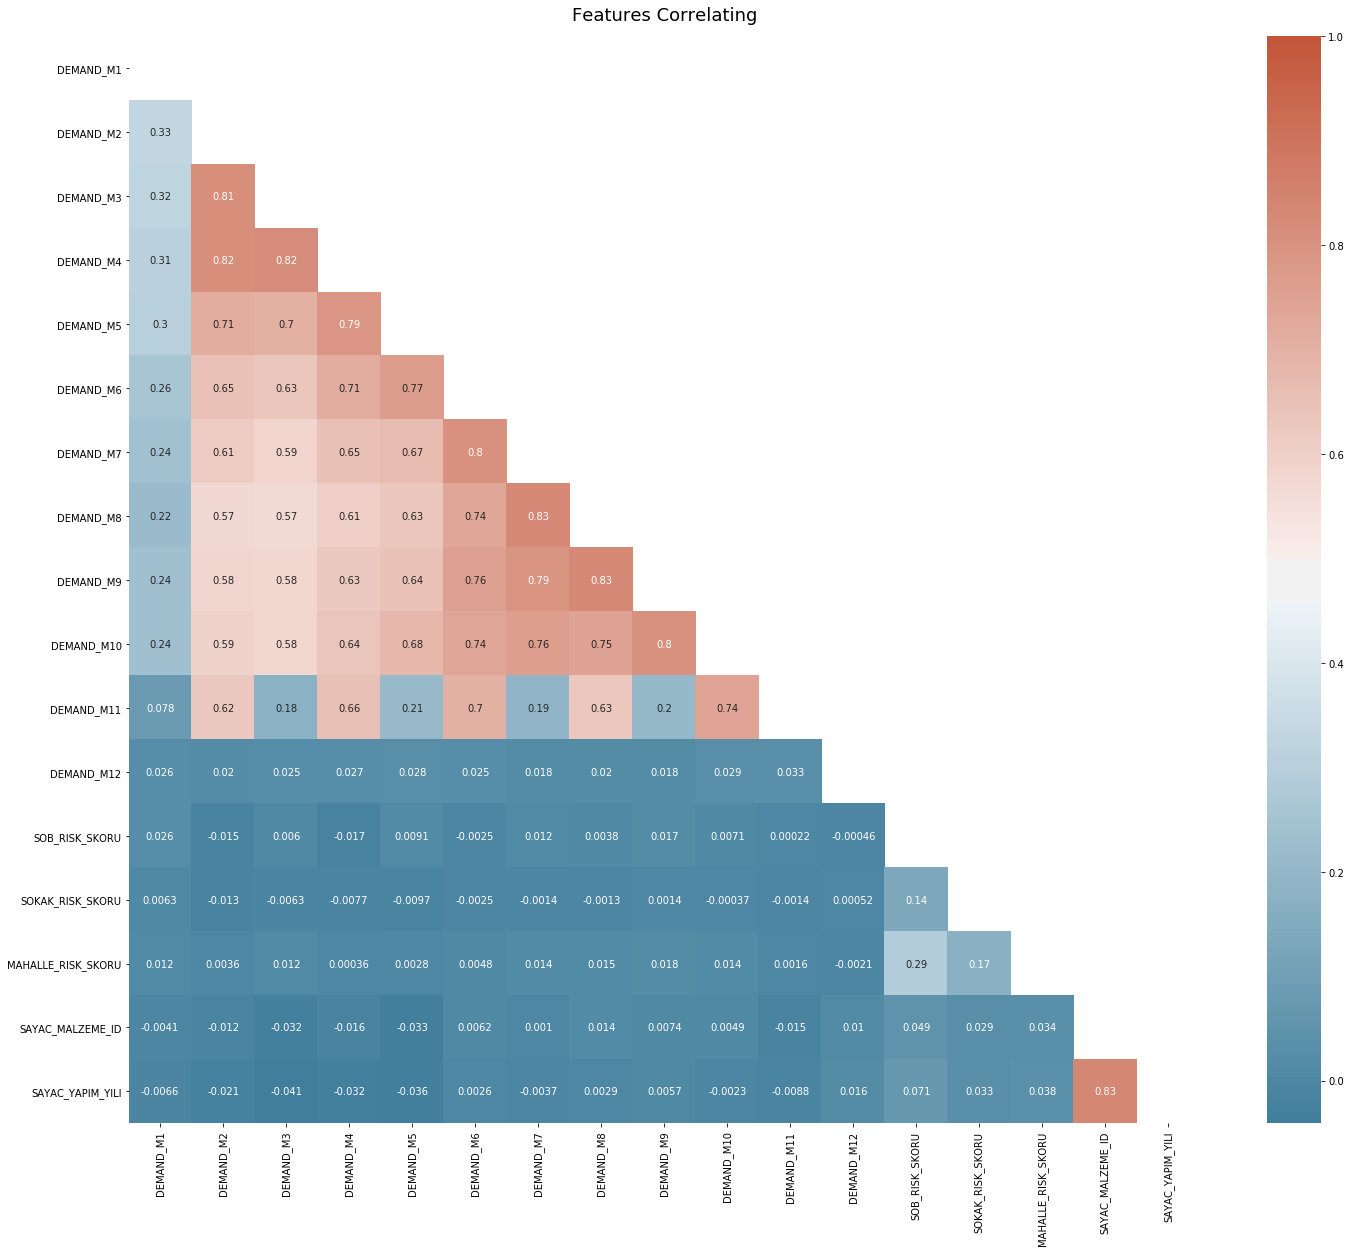

In [359]:
num_values2 = num_values.iloc[:,24:]

corr = num_values2.corr()

f, ax = plt.subplots(figsize=(24, 20))

mask = np.triu(np.ones_like(corr, dtype=bool))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

heatmap = sns.heatmap(corr, annot=True, mask = mask, cmap=cmap);
heatmap.set_title('Features Correlating', fontdict={'fontsize':18}, pad=16);

<br>
Demand değişkeni, anlık olarak çekilen en yüksek elektrik miktarını göstermektedir. Buradaki önemli nokta ise anlık olarak çekilen bu değerin yüksek olması, o ay içerisinde yüksek miktarda elektrik kullandığını göstermemektedir. Bu anlık tüketim miktarı örneğin bir dakika için diğer tüm aylardan çok yüksek olup geri kalan zamanda diğer aylardan daha düşük olabilir. Burdan çıkarılacak sonuç ise tüketim miktarı ile demand miktarı arasında ilişki kurulamayacağı. Hatta diğer kullanıcıların demand miktarı ya da diğer aylardaki demand miktarları arasında da mantıksal olarak ilişki kurmak yanlış olur. Risk skorlarının korelasyon değerlerinin düşük olması, bu skorların belirli değişkenlere sahip olabileceği mesajını veriyor. Bu verileri daha yakından inceleyerek veri setimizi daha yakından tanıyacağız fakat şimdi de kategorik değişkenleri target değişkenimizle analiz edelim.
<br>

In [360]:
full_table.iloc[:,:24].describe().T

,count,mean,std,min,25%,50%,75%,max
TUKETIM_M1,15000.0,96.208479,423.739447,0.0000,18.663720,57.967004,119.764778,47318.985000
TUKETIM_M2,15000.0,205.978455,806.797729,0.0000,67.464279,147.897623,244.215963,90851.355000
TUKETIM_M3,15000.0,223.982149,562.430605,0.0000,72.497774,156.901631,267.343281,47803.770000
TUKETIM_M4,15000.0,217.158467,1388.820828,0.0000,71.253761,152.988106,251.375305,162381.240000
TUKETIM_M5,15000.0,183.984799,1311.605920,0.0000,70.489054,136.929436,203.995790,111955.470968
TUKETIM_M6,15000.0,184.405282,1063.798858,0.0000,72.638329,138.537125,201.954775,95467.680000
TUKETIM_M7,15000.0,215.505007,1162.260886,0.0000,78.729780,151.135455,238.281348,110822.519806
TUKETIM_M8,15000.0,248.644492,1100.215516,0.0000,81.960615,167.395119,288.195682,112852.579355
TUKETIM_M9,15000.0,232.900504,1112.950045,0.0000,77.956021,156.945536,261.602692,98479.082839
TUKETIM_M10,15000.0,205.188164,1337.520990,0.0000,74.530854,144.954876,224.807583,142768.472000


In [361]:
full_table.iloc[:,24:36].describe().T

,count,mean,std,min,25%,50%,75%,max
DEMAND_M1,14929.0,2.965882,5.583334,0.0,1.344,2.508,4.048,617.000
DEMAND_M2,12612.0,3.398323,2.748383,0.0,1.776,2.940,4.816,65.428
DEMAND_M3,14217.0,3.289800,2.760945,0.0,1.664,2.812,4.736,96.736
DEMAND_M4,12631.0,3.142504,2.494704,0.0,1.612,2.716,4.420,66.698
DEMAND_M5,14055.0,2.676995,2.066277,0.0,1.492,2.388,3.544,39.951
DEMAND_M6,12418.0,2.304148,1.930819,0.0,1.108,2.172,3.016,42.688
DEMAND_M7,13978.0,2.371124,1.969826,0.0,1.280,2.232,3.152,55.620
DEMAND_M8,12243.0,2.434009,2.084839,0.0,1.084,2.268,3.356,56.088
DEMAND_M9,13766.0,2.298214,1.916677,0.0,1.044,2.160,3.120,48.259
DEMAND_M10,12242.0,2.584867,2.020813,0.0,1.480,2.372,3.384,43.868


<h4>Kategorik verilerin ilişkileri</h4>

NK_FLAG = 0 için Tesisat Tipi Dağılımları :
---------------------------------------------------------------------------
Mesken                12550
Ticarethane-Sanayi     1430
Name: TESISAT_TIPI, dtype: int64 

NK_FLAG = 1 için Tesisat Tipi Dağılımları :
---------------------------------------------------------------------------
Mesken                841
Ticarethane-Sanayi    179
Name: TESISAT_TIPI, dtype: int64 



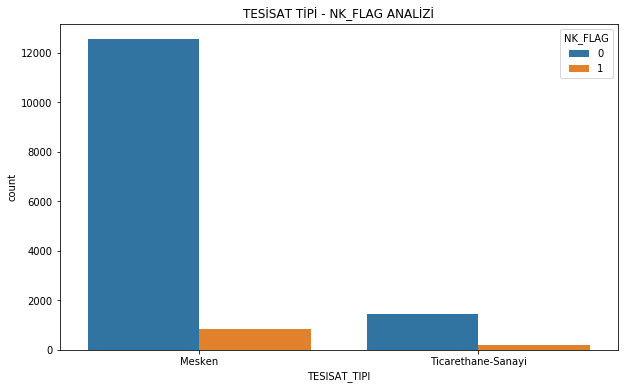

In [362]:
tes_tip0 = full_table[(full_table['NK_FLAG'] == 0)]
tes_tip1 = full_table[(full_table['NK_FLAG'] == 1)]

print('NK_FLAG = 0 için Tesisat Tipi Dağılımları :')
print('-'*75)
print(tes_tip0['TESISAT_TIPI'].value_counts(), '\n')

print('NK_FLAG = 1 için Tesisat Tipi Dağılımları :')
print('-'*75)
print(tes_tip1['TESISAT_TIPI'].value_counts(), '\n')

fig, axes = plt.subplots(figsize=(10, 6))
sns.countplot(x= "TESISAT_TIPI", hue="NK_FLAG", data=full_table).set_title("TESİSAT TİPİ - NK_FLAG ANALİZİ");

NK_FLAG = 0 için SAYAÇ MARKA Dağılımları :
---------------------------------------------------------------------------
LUNA          5893
ELEKTROMED    5328
VI-KO         1174
MAKEL          816
KOHLER         664
KAAN            35
NORA            17
ALFATECH        16
DMA              6
Name: SAYAC_MARKA, dtype: int64 

NK_FLAG = 1 için Tesisat Tipi Dağılımları :
---------------------------------------------------------------------------
LUNA          695
ELEKTROMED    202
VI-KO          56
MAKEL          24
KOHLER         22
KAAN            1
ALFATECH        1
Name: SAYAC_MARKA, dtype: int64 



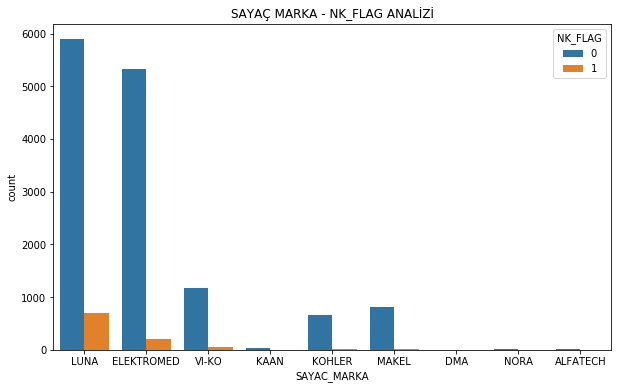

In [363]:
say_mar0 = full_table[(full_table['NK_FLAG'] == 0)]
say_mar1 = full_table[(full_table['NK_FLAG'] == 1)]

print('NK_FLAG = 0 için SAYAÇ MARKA Dağılımları :')
print('-'*75)
print(say_mar0['SAYAC_MARKA'].value_counts(), '\n')

print('NK_FLAG = 1 için Tesisat Tipi Dağılımları :')
print('-'*75)
print(say_mar1['SAYAC_MARKA'].value_counts(), '\n')

fig, axes = plt.subplots(figsize=(10, 6))
sns.countplot(x= "SAYAC_MARKA", hue="NK_FLAG", data=full_table).set_title("SAYAÇ MARKA - NK_FLAG ANALİZİ");

NK_FLAG = 0 için SAYAÇ MARKA Dağılımları :
---------------------------------------------------------------------------
EC058MBW        3334
LUN10           2112
LUN10-B         1799
LUN1            1446
VEM-M580DB0E     864
                ... 
KHL.ES6            1
VEM-C5100DB2       1
M310.2216          1
AEL.TF.04-2        1
VEM-M580DB2        1
Name: SAYAC_MODEL, Length: 70, dtype: int64 

NK_FLAG = 1 için Tesisat Tipi Dağılımları :
---------------------------------------------------------------------------
LUN10-B          462
LUN10            128
EC058MBW         113
EC058MCT          63
VEM-M580DB0E      42
LSM-35            33
LUN1              33
EC018MBW          17
AEL.MF.07         12
LSM10-BUZ         11
EC15ATBW           7
LSM40-BUZ-KOM      7
M500.2251          7
VEM-T5100DB0E      6
AEL.TF.16-2        6
VEM-M580DB0        5
LUN23 TF           5
LUN10 HBR          5
M310.2218          4
M600.2251          4
T510.2251          3
LUN21              3
M500.2211          3
L

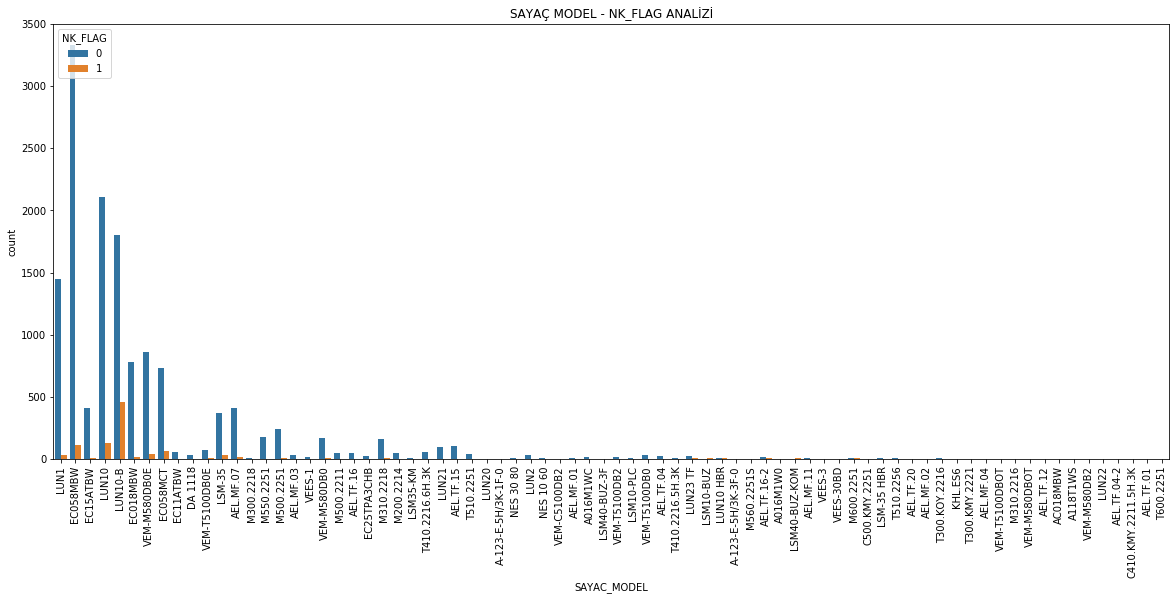

In [364]:
say_mod0 = full_table[(full_table['NK_FLAG'] == 0)]
say_mod1 = full_table[(full_table['NK_FLAG'] == 1)]

print('NK_FLAG = 0 için SAYAÇ MARKA Dağılımları :')
print('-'*75)
print(say_mod0['SAYAC_MODEL'].value_counts(), '\n')

print('NK_FLAG = 1 için Tesisat Tipi Dağılımları :')
print('-'*75)
print(say_mod1['SAYAC_MODEL'].value_counts(), '\n')

fig, axes = plt.subplots(figsize=(20, 8))
sns.countplot(x= "SAYAC_MODEL", hue="NK_FLAG", data=full_table).set_title("SAYAÇ MODEL - NK_FLAG ANALİZİ");
plt.xticks(rotation=90);

NK_FLAG = 0 için SAYAÇ MARKA Dağılımları :
---------------------------------------------------------------------------
Aktif    13912
Kombi       37
Name: SAYAC_OLCUM_TURU, dtype: int64 

NK_FLAG = 1 için Tesisat Tipi Dağılımları :
---------------------------------------------------------------------------
Aktif    990
Kombi     11
Name: SAYAC_OLCUM_TURU, dtype: int64 



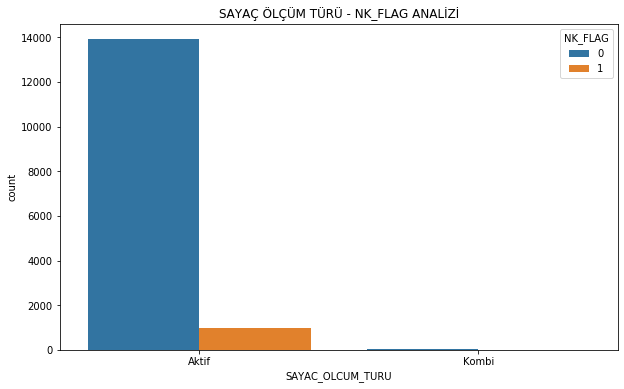

In [365]:
say_olc0 = full_table[(full_table['NK_FLAG'] == 0)]
say_olc1 = full_table[(full_table['NK_FLAG'] == 1)]

print('NK_FLAG = 0 için SAYAÇ MARKA Dağılımları :')
print('-'*75)
print(say_olc0['SAYAC_OLCUM_TURU'].value_counts(), '\n')

print('NK_FLAG = 1 için Tesisat Tipi Dağılımları :')
print('-'*75)
print(say_olc1['SAYAC_OLCUM_TURU'].value_counts(), '\n')

fig, axes = plt.subplots(figsize=(10, 6))
sns.countplot(x= "SAYAC_OLCUM_TURU", hue="NK_FLAG", data=full_table).set_title("SAYAÇ ÖLÇÜM TÜRÜ - NK_FLAG ANALİZİ");

NK_FLAG = 0 için SAYAÇ MARKA Dağılımları :
---------------------------------------------------------------------------
Monofaze    12472
Trifaze      1477
Name: SAYAC_FAZ_N, dtype: int64 

NK_FLAG = 1 için Tesisat Tipi Dağılımları :
---------------------------------------------------------------------------
Monofaze    918
Trifaze      83
Name: SAYAC_FAZ_N, dtype: int64 



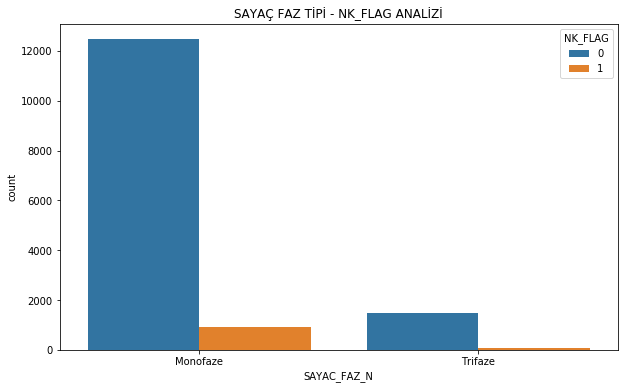

In [366]:
say_faz0 = full_table[(full_table['NK_FLAG'] == 0)]
say_faz1 = full_table[(full_table['NK_FLAG'] == 1)]

print('NK_FLAG = 0 için SAYAÇ MARKA Dağılımları :')
print('-'*75)
print(say_faz0['SAYAC_FAZ_N'].value_counts(), '\n')

print('NK_FLAG = 1 için Tesisat Tipi Dağılımları :')
print('-'*75)
print(say_faz1['SAYAC_FAZ_N'].value_counts(), '\n')

fig, axes = plt.subplots(figsize=(10, 6))
sns.countplot(x= "SAYAC_FAZ_N", hue="NK_FLAG", data=full_table).set_title("SAYAÇ FAZ TİPİ - NK_FLAG ANALİZİ");

In [367]:
for i in cat_values:
    print(i, 'kolonundaki NaN veri sayısı :', full_table[i].isnull().sum())
print('-'*50)

print('\n\nTESİSAT TİPİ VERİLERİ & SAYAÇ FAZ N VERİLERİ')
print('-'*50)
print(full_table['TESISAT_TIPI'].value_counts(), '\n\n',full_table['SAYAC_FAZ_N'].value_counts())

TESISAT_TIPI kolonundaki NaN veri sayısı : 0
SAYAC_BITIS_TARIHI kolonundaki NaN veri sayısı : 50
SAYAC_MARKA kolonundaki NaN veri sayısı : 50
SAYAC_MODEL kolonundaki NaN veri sayısı : 50
SAYAC_OLCUM_TURU kolonundaki NaN veri sayısı : 50
SAYAC_FAZ_N kolonundaki NaN veri sayısı : 50
--------------------------------------------------


TESİSAT TİPİ VERİLERİ & SAYAÇ FAZ N VERİLERİ
--------------------------------------------------
Mesken                13391
Ticarethane-Sanayi     1609
Name: TESISAT_TIPI, dtype: int64 

 Monofaze    13390
Trifaze      1560
Name: SAYAC_FAZ_N, dtype: int64


<br>
<b>TESISAT_TIPI</b> ve <b>SAYAC_FAZ_N</b> verileri birbirleriyle karşılaştırıldıklarında Mesken ve Monofaze, Ticarethane-Sanayi ve Trifaze arasında veri  sayısı benzerliği dikkat çekiyor. Biraz alan araştırması sonucunda Monofaze tipi sayaçların daha çok meskenlere, Trifaze tipi sayaçların ise çoğunlukla sanayi yerlerinde kullanıldığını öğrendik. Bu durumdan çıkaracağımız sonuç ise, <b>SAYAC_FAZ_N</b> kolonunda yer alan 50 adet eksik veriyi <b>TESISAT_TIPI</b> değişkenine göre doldurabiliriz.
<br>

<br>
<h4>Tarihler!</h4>
<br>

Veri tipi tarih olan değişkenlerimizle neler yapabileceklerimize bakalım.

In [368]:
full_table[['SAYAC_BASLANGIC_TARIHI', 'SAYAC_TAKILMA_TARIHI', 'SAYAC_BITIS_TARIHI']]

,SAYAC_BASLANGIC_TARIHI,SAYAC_TAKILMA_TARIHI,SAYAC_BITIS_TARIHI
0,2016-10-18,2016-10-18,9999-12-31 00:00:00
1,2016-09-25,2016-09-25,9999-12-31 00:00:00
2,2016-10-11,2016-10-11,9999-12-31 00:00:00
3,2016-05-24,2016-05-24,9999-12-31 00:00:00
4,2018-05-30,2018-05-30,9999-12-31 00:00:00
...,...,...,...
14995,2017-09-06,2017-09-06,9999-12-31 00:00:00
14996,2016-10-06,2016-10-06,9999-12-31 00:00:00
14997,2016-09-28,2016-09-28,9999-12-31 00:00:00
14998,2016-10-12,2016-10-12,9999-12-31 00:00:00


<br>Verileri incelediğimizde sayaç başlangıç tarihi ile sayaç takılma tarihinin benzer değerler içerdiği anlaşılıyor, sayaç bitiş tarihinin ise aynı değerlerden oluştuğu tahmin ediliyor. Bunları daha yakından inceleyelim.<br>

In [369]:
equal_dates = full_table[(full_table['SAYAC_BASLANGIC_TARIHI'] == full_table["SAYAC_TAKILMA_TARIHI"])]
print('\nBirbiriyle aynı tarih değerine sahip satır sayısı :', equal_dates.shape[0],'\n')

diff_dates = full_table[(full_table['SAYAC_BASLANGIC_TARIHI'] != full_table["SAYAC_TAKILMA_TARIHI"])]
print('EŞİT OLMAYAN DEĞERLERİN KARŞILAŞTIRILMASI:')
print('-'*50)
print(diff_dates[['SAYAC_BASLANGIC_TARIHI','SAYAC_TAKILMA_TARIHI']].head(5))

print('\nEKSİK DEĞER SAYISI:')
print('-'*50)
print('Sayaç Başlangıç Tarihi eksik değer sayısı :', diff_dates.SAYAC_BASLANGIC_TARIHI.isnull().sum())
print('Sayaç Takılma Tarihi eksik değer sayısı   :', diff_dates.SAYAC_TAKILMA_TARIHI.isnull().sum())

print('\nSAYAÇ BİTİŞ TARİHİ VERİLERİ')
print('-'*50)
print(full_table['SAYAC_BITIS_TARIHI'].value_counts())


Birbiriyle aynı tarih değerine sahip satır sayısı : 14950 

EŞİT OLMAYAN DEĞERLERİN KARŞILAŞTIRILMASI:
--------------------------------------------------
    SAYAC_BASLANGIC_TARIHI SAYAC_TAKILMA_TARIHI
318                    NaT                  NaT
536                    NaT                  NaT
553                    NaT                  NaT
565                    NaT                  NaT
855                    NaT                  NaT

EKSİK DEĞER SAYISI:
--------------------------------------------------
Sayaç Başlangıç Tarihi eksik değer sayısı : 50
Sayaç Takılma Tarihi eksik değer sayısı   : 50

SAYAÇ BİTİŞ TARİHİ VERİLERİ
--------------------------------------------------
9999-12-31 00:00:00    14950
Name: SAYAC_BITIS_TARIHI, dtype: int64


<br>
<b>SAYAC_BASLANGIC_TARIHI</b> ile <b>SAYAC_TAKILMA_TARIHI</b> değişkenleri birbirleriyle yukarıda karşılaştırıldı ve 14950 değerin birbiriyle aynı olduğu keşfedildi. Geriye kalan 50 değişken incelendiğinde de hepsinin NaN veri olduğu anlaşıldı. Bu durumda NaN veriler birbirleri ile karşılaştırılarak doldurulmayacağı anlaşıldı. Bu durumda değişkenlerden birisini yok etmek gayet mantıklı olacaktır. Diğer tarih değişkeni de kullanılabilir mi onu ilerdeki analizde keşfedeceğiz. Bir diğer değişken olan <b>SAYAC_BITIS_TARIHI</b>'nde ise 14950 verinin aynı değere sahiptir, bu sebeple bu kolonla da yollarımızı ayırmak için not ediyoruz. 
<br>

Sayaç Yapım Yılı İçin Değişken Sayıları:
--------------------------------------------------
2016.0    3336
2017.0    2300
2014.0    1523
2012.0    1438
2015.0    1431
2013.0    1394
2011.0    1313
2019.0     930
2010.0     597
2018.0     577
2020.0     104
2009.0       3
2008.0       2
2007.0       2
Name: SAYAC_YAPIM_YILI, dtype: int64 



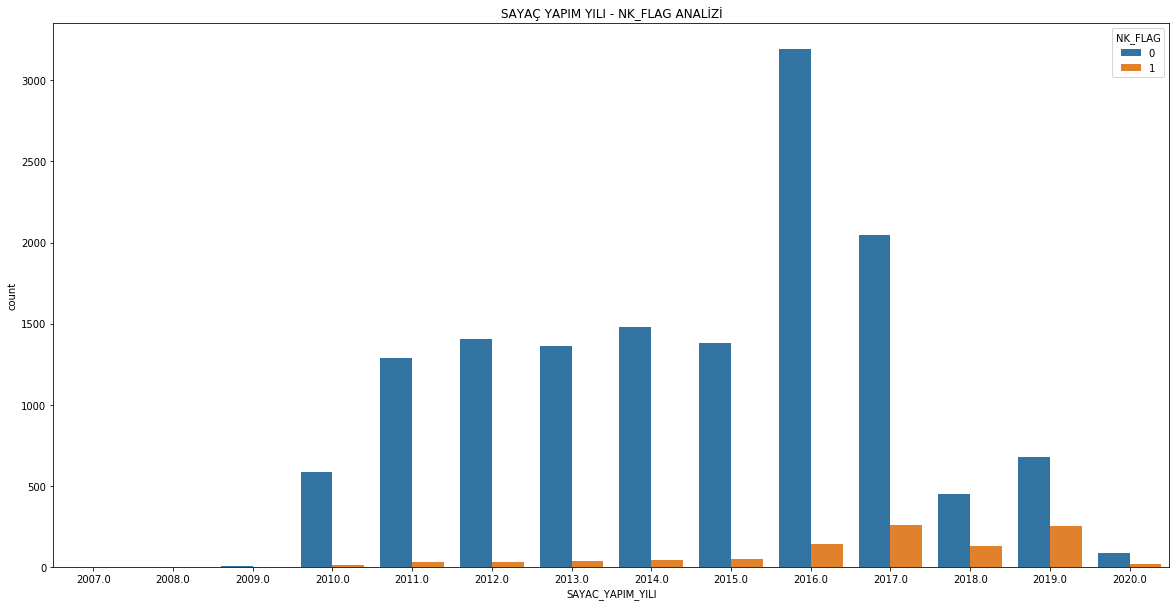

In [370]:
print('Sayaç Yapım Yılı İçin Değişken Sayıları:')
print('-'*50)
print(full_table['SAYAC_YAPIM_YILI'].value_counts(), '\n')

fig, axes = plt.subplots(figsize=(20, 10))
sns.countplot(x= "SAYAC_YAPIM_YILI", hue="NK_FLAG", data=full_table).set_title("SAYAÇ YAPIM YILI - NK_FLAG ANALİZİ");

In [371]:
full_table['NK_FLAG'].value_counts()

0    13980
1     1020
Name: NK_FLAG, dtype: int64

<h3>Kayıp Veriler!</h3>

In [373]:
tuk_val = full_table.iloc[:,0:24]
zero_tuk_val = tuk_val[tuk_val.eq(0).all(axis=1)]
index_zero_tuk = zero_tuk_val.index.tolist()
zero_tuk_result = full_table.iloc[index_zero_tuk, :]
zero_tuk_result.iloc[:,:24]

,TUKETIM_M1,TUKETIM_M2,TUKETIM_M3,TUKETIM_M4,TUKETIM_M5,TUKETIM_M6,TUKETIM_M7,TUKETIM_M8,TUKETIM_M9,TUKETIM_M10,...,TUKETIM_M15,TUKETIM_M16,TUKETIM_M17,TUKETIM_M18,TUKETIM_M19,TUKETIM_M20,TUKETIM_M21,TUKETIM_M22,TUKETIM_M23,TUKETIM_M24
35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14555,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [374]:
zero_tuk_result.iloc[:,24:36]

,DEMAND_M1,DEMAND_M2,DEMAND_M3,DEMAND_M4,DEMAND_M5,DEMAND_M6,DEMAND_M7,DEMAND_M8,DEMAND_M9,DEMAND_M10,DEMAND_M11,DEMAND_M12
35,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
147,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
14231,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14555,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [375]:
zero_tuk_result.iloc[:, :36].describe().T

,count,mean,std,min,25%,50%,75%,max
TUKETIM_M1,137.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000
TUKETIM_M2,137.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000
TUKETIM_M3,137.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000
TUKETIM_M4,137.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000
TUKETIM_M5,137.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000
TUKETIM_M6,137.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000
TUKETIM_M7,137.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000
TUKETIM_M8,137.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000
TUKETIM_M9,137.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000
TUKETIM_M10,137.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000


<br>Tam olarak 137 sütunda ki bütün <b>TUKETIM_Mx</b> değerleri sıfır'dır. Bu ilginç bir durum, iki yıl boyunca evde hiç elektrik kullanılmadığı anlamına geliyor. Yani kişi ya iki yıldır tatilde, ya da iki yıldır kaçak elektrik kullanıyor. Tabii tüm bu veriler hatalı değilse. Tüketim değerlerinin tamamen sıfır olduğu durumlarda <b>DEMAND_Mx</b> değerlerine baktığımızda da aynı şekilde onlarda sıfırlardan ya da tamamen 1'lerden oluşmaktadır fakat tüketimden farklı olarak demand değişkenlerde NaN veriler de bulunmaktadır. Tüm bu şartlar verileri temizlememizi gösteriyor gibi fakat son ve önemli bir kontrol gerçekleştirmek gerekiyor.</br>

In [376]:
zero_tuk_result['NK_FLAG'].value_counts()

0    136
1      1
Name: NK_FLAG, dtype: int64

Tüm tüketim verilerinin sıfır ve deman değerlerinin sıfır ve NaN değerlerinden oluştuğu verilerde toplam 1 adet NK_FLAG = 1 durumu vardır. Yani bu veriler tamamen işlenmeye değmeyecek şekilde gözükmektedir dolayısıyla tüm bunları temizleyebiliriz.

In [400]:
processed_table = full_table.copy()

In [401]:
print('İlk hali ile toplam satır sayısı             :',full_table.shape[0])

processed_table.drop(index_zero_tuk, inplace=True)
print('Temizleme işlemi sonrası toplam satır sayısı :', processed_table.shape[0])
processed_table.reset_index(drop=True, inplace=True)

İlk hali ile toplam satır sayısı             : 15000
Temizleme işlemi sonrası toplam satır sayısı : 14863


In [403]:
processed_table['SAYAC_TAKILMA_TARIHI'] = pd.to_datetime(processed_table['SAYAC_TAKILMA_TARIHI'])
processed_table['SAYAC_TAKILMA_TARIHI'] = processed_table['SAYAC_TAKILMA_TARIHI'].fillna(pd.Timestamp("20161014"))

df1 = processed_table.copy()

dict1 = {}

for i in range(len(df1['SAYAC_TAKILMA_TARIHI'].dt.month)):
    
    a = int(df1['SAYAC_TAKILMA_TARIHI'].dt.month[i])

    if len(dict1) == 0:
        for kk in range(1,a):
            b = df1.iloc[i][24-a+kk]
            dict1[f"TUKETIM_M{kk}"] = [b]
        for k in range(24-a+1): 
            b = df1.iloc[i][k]
            dict1[f"TUKETIM_M{a+k}"] = [b]
    else:
        for kk in range(1,a):
            b = df1.iloc[i][24-a+kk]
            dict1[f"TUKETIM_M{kk}"].append(b)
        for k in range(24-a+1):
            b = df1.iloc[i][k]
            dict1[f"TUKETIM_M{a+k}"].append(b)
    
test1 = pd.DataFrame.from_dict(dict1)
processed_table = pd.concat([test1, processed_table.iloc[:,24:]], axis=1)
processed_table

,TUKETIM_M1,TUKETIM_M2,TUKETIM_M3,TUKETIM_M4,TUKETIM_M5,TUKETIM_M6,TUKETIM_M7,TUKETIM_M8,TUKETIM_M9,TUKETIM_M10,...,SAYAC_BASLANGIC_TARIHI,SAYAC_BITIS_TARIHI,SAYAC_MARKA,SAYAC_MODEL,SAYAC_MALZEME_ID,SAYAC_OLCUM_TURU,SAYAC_FAZ_N,SAYAC_TAKILMA_TARIHI,SAYAC_YAPIM_YILI,NK_FLAG
0,273.352000,266.875034,309.120407,326.750892,354.539943,318.070421,330.373589,345.701621,327.902260,54.067286,...,2016-10-18,9999-12-31 00:00:00,LUNA,LUN1,80000107.0,Aktif,Monofaze,2016-10-18,2012.0,0
1,215.697424,202.549150,230.007616,239.995010,226.454837,220.314917,218.741546,211.675245,125.413387,227.864889,...,2016-09-25,9999-12-31 00:00:00,ELEKTROMED,EC058MBW,80000731.0,Aktif,Monofaze,2016-09-25,2015.0,0
2,211.346271,238.872425,257.272032,294.784710,283.357450,226.819491,230.758659,206.737582,194.363068,308.273107,...,2016-10-11,9999-12-31 00:00:00,ELEKTROMED,EC15ATBW,80000732.0,Aktif,Trifaze,2016-10-11,2016.0,0
3,22.798067,18.199133,18.319485,24.635136,23.105143,49.197286,64.653696,73.807875,31.418710,31.834563,...,2016-05-24,9999-12-31 00:00:00,LUNA,LUN10,80000710.0,Aktif,Monofaze,2016-05-24,2016.0,0
4,594.512266,672.500911,46.106609,0.000000,36.016793,48.795995,50.209868,50.969201,49.746943,89.461700,...,2018-05-30,9999-12-31 00:00:00,LUNA,LUN10-B,80001006.0,Aktif,Monofaze,2018-05-30,2017.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14858,385.612478,285.438594,345.162857,454.418433,368.258606,282.695716,260.547200,214.292877,48.759310,242.282118,...,2017-09-06,9999-12-31 00:00:00,LUNA,LUN10,80000710.0,Aktif,Monofaze,2017-09-06,2016.0,0
14859,317.261615,176.094785,174.265989,184.060482,247.209504,150.804522,201.667942,182.571226,194.766694,22.899931,...,2016-10-06,9999-12-31 00:00:00,ELEKTROMED,EC058MBW,80000731.0,Aktif,Monofaze,2016-10-06,2014.0,0
14860,176.198129,130.197871,76.019394,137.823139,140.514918,103.472215,110.678833,106.792000,35.103419,146.619759,...,2016-09-28,9999-12-31 00:00:00,LUNA,LUN1,80000107.0,Aktif,Monofaze,2016-09-28,2012.0,0
14861,0.051321,0.052439,9.199279,54.265455,93.855506,6.811857,18.144267,32.781626,0.040774,1.191094,...,2016-10-12,9999-12-31 00:00:00,KOHLER,AEL.MF.07,80000526.0,Aktif,Monofaze,2016-10-12,2013.0,0


In [406]:
processed_table_v1 = processed_table.copy()

<br>
Yukarıda tüketim için tamamı sıfır olan ve demand için sıfır ve NaN değerlerden oluşan satırları temizledik. Sadece NK_FLAG = 1 olan değişkene sahip index'e dokunmadık. Onu da daha sonrasında işlemek üzere not ettik. Şimdi de demand değişkeninin tamamı sıfır olan değişkenlere bakalım.
<br>

In [410]:
dem_val = processed_table_v1.iloc[:,24:36]
zero_dem_val = dem_val[dem_val.eq(0).all(axis=1)]
index_zero_dem = zero_dem_val.index.tolist()
zero_dem_result = processed_table_v1.iloc[index_zero_dem, :]
zero_dem_result.iloc[:,24:36]

,DEMAND_M1,DEMAND_M2,DEMAND_M3,DEMAND_M4,DEMAND_M5,DEMAND_M6,DEMAND_M7,DEMAND_M8,DEMAND_M9,DEMAND_M10,DEMAND_M11,DEMAND_M12
92,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
892,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
910,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
13616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [411]:
zero_dem_result.iloc[:,:24].describe().T

,count,mean,std,min,25%,50%,75%,max
TUKETIM_M1,61.0,14.945404,40.661796,0.0,0.0,0.0,1.475428,217.289933
TUKETIM_M2,62.0,18.250580,46.088358,0.0,0.0,0.0,1.633942,239.589376
TUKETIM_M3,63.0,14.496254,39.589214,0.0,0.0,0.0,0.774995,189.387096
TUKETIM_M4,62.0,17.412236,51.779788,0.0,0.0,0.0,1.159807,320.952618
TUKETIM_M5,62.0,17.224279,51.166577,0.0,0.0,0.0,0.906102,302.115028
TUKETIM_M6,63.0,25.292180,97.180766,0.0,0.0,0.0,0.756331,712.856000
TUKETIM_M7,63.0,46.596282,291.483148,0.0,0.0,0.0,0.044321,2307.351923
TUKETIM_M8,64.0,47.118571,294.593913,0.0,0.0,0.0,0.293058,2352.346744
TUKETIM_M9,64.0,31.166172,181.072394,0.0,0.0,0.0,0.013000,1434.078430
TUKETIM_M10,64.0,19.640090,126.311380,0.0,0.0,0.0,0.000000,1002.867800


<br><b>DEMAND_Mx</b> değişkenlerinin tamamen 0 olduğu durumlarda <b>TUKETIM_Mx</b> değişkenleri farklı değerler alabiliyor. Her ne kadar aldığı değerlerin yoğunluğu sıfır olsa da, tamamı sıfır ya da NaN değerlerden oluşmadığı için bize bir anlam ifade edebilir. Bu yüzden bu değişkenleri temizlemiyoruz.</br>

<br>
<b>TUKETIM_Mx</b>'den başlayıp <b>DEMAND_Mx</b>'in sonuna kadar tamamen sıfırdan oluşan bir satır kalmadığını da yukardaki kod parçasıyla teyit etmiş olduk.
<br>

In [412]:
drop_col = ['SAYAC_BASLANGIC_TARIHI', 'SAYAC_TAKILMA_TARIHI', 'SAYAC_BITIS_TARIHI' ,'SAYAC_MALZEME_ID']
processed_table_v1.drop(columns=drop_col, inplace=True)

<br>
Silinen kolonlar için:
<ul>
<li><b>SAYAC_TAKILMA_TARIHI</b> kolonu, <b>SAYAC_BASLANGIC_TARIHI<b> kolonu ile aynı verileri içerdiği için silinme kararı alındı</li>
<li><b>SAYAC_BITIS_TARIHI</b>'nde yer alan tüm veriler aynı olduğu için silinme kararı alındı</li>
<li><b>SAYAC_MALZEME_ID</b> kolonunu bir anlam ifade etmediği ve <b>SAYAC_MODEL</b> ile benzer olduğu için silinme kararı alındı.</li>
</ul>
<br>

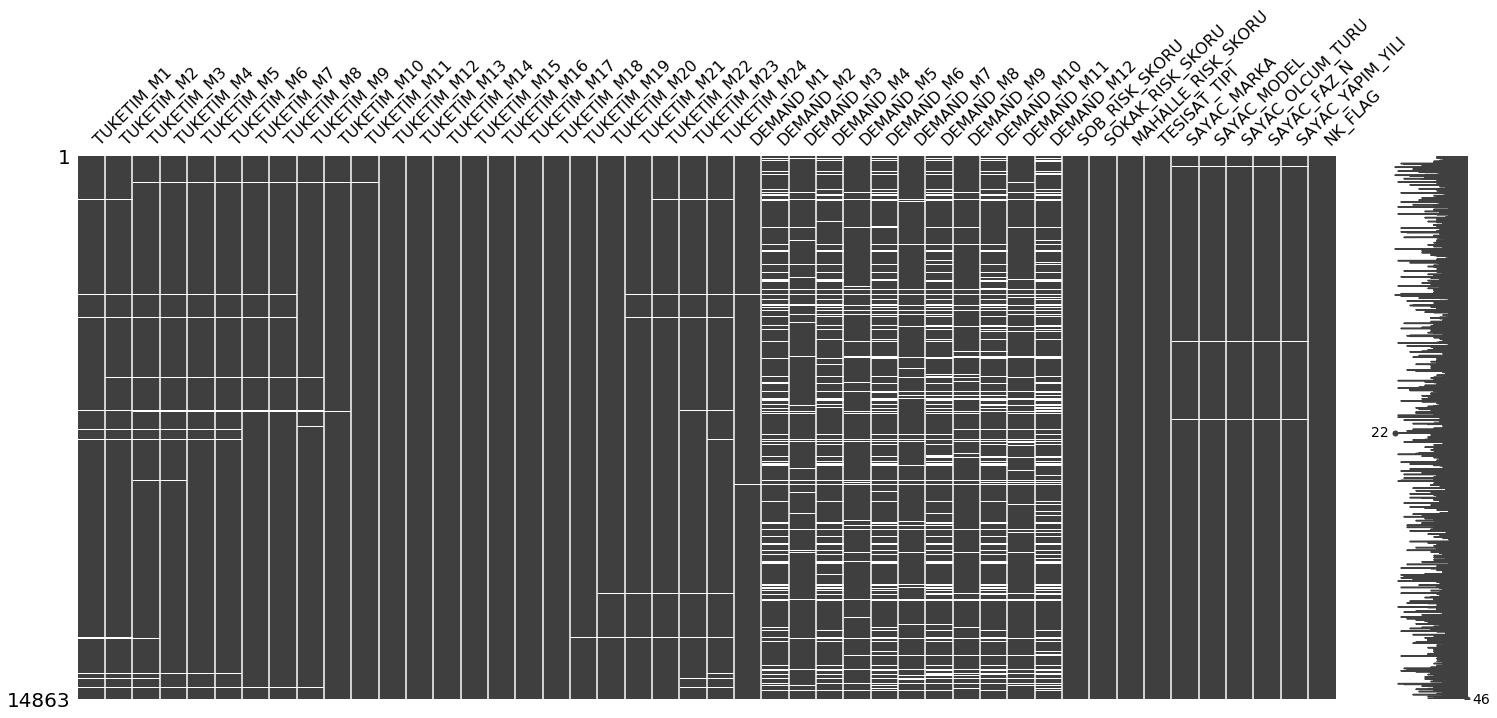

In [413]:
msno.matrix(processed_table_v1)

<br>
Bu zamana kadar yaptığımız işlemler sonucunda elimizde kalan verilerin doluluk oranı yukarıdaki grafikte yer almaktadır. Grafiğe baktığımızda <b>DEMAND_Mx</b> değerleri hariç nerdeyse NaN veri olmadığı, DEMAND_Mx değerinin ise kurtarılabilir olduğu gözükmektedir. Şimdi NaN verileri doldurma işlemine geçebiliriz.
<br>

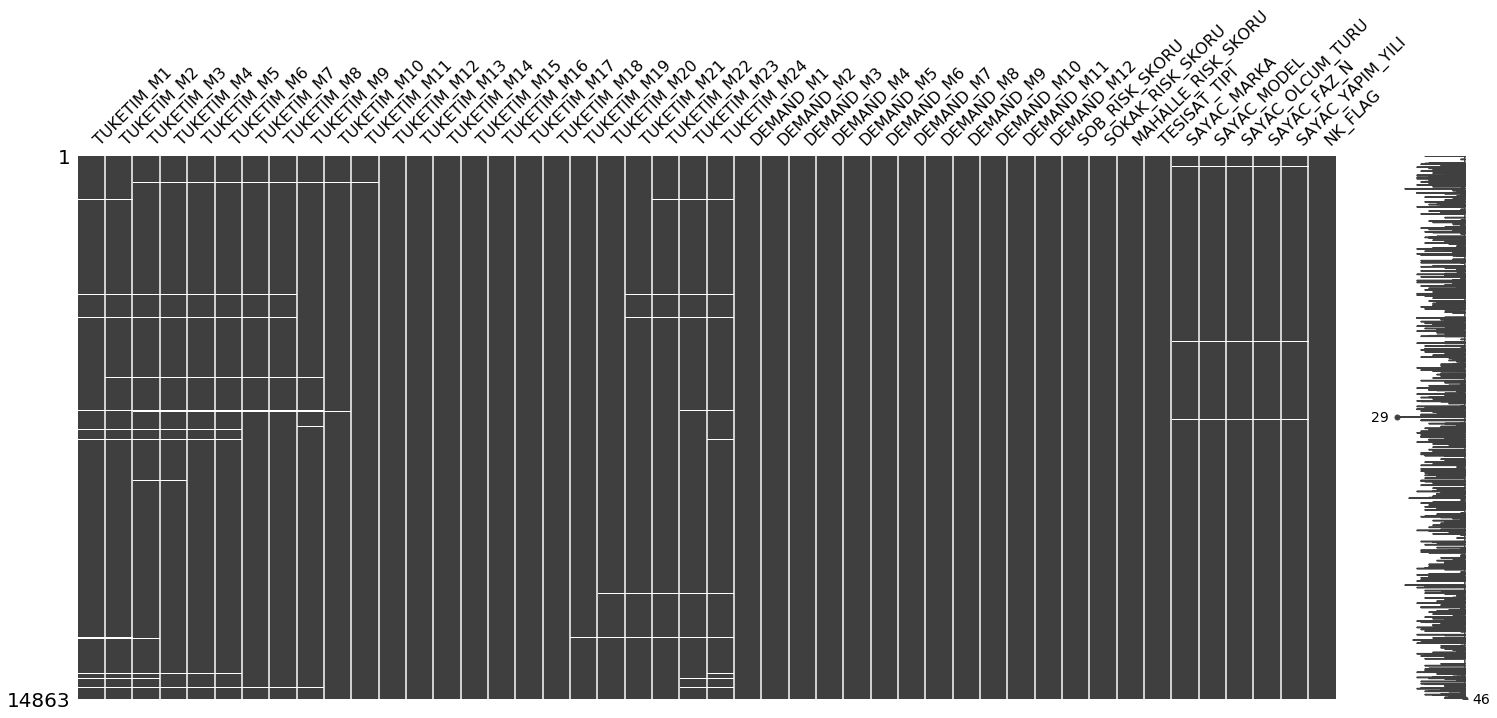

In [422]:
col_zero = processed_table_v1.iloc[:,24:39].columns.to_list()
processed_table_v1[col_zero] = processed_table_v1[col_zero].fillna(0)
msno.matrix(processed_table_v1)

<br>
Nümerik verilerin tamamında NaN verileri düzenledik. Bundan sonraki aşamada ise kategorik değişkenlerde yer alan NaN verileri ele alacağız. Öncelikle hangi kolonda ne kadar kategorik değişken var ona bakalım.
</br>

In [423]:
print(processed_table_v1['TESISAT_TIPI'].value_counts(), '\n', processed_table_v1['SAYAC_FAZ_N'].value_counts())

tic_val = processed_table_v1[(processed_table_v1['TESISAT_TIPI'] == 'Ticarethane-Sanayi')]
tic_val = tic_val[(tic_val['SAYAC_FAZ_N'] != 'Monofaze') & (tic_val['SAYAC_FAZ_N'] != 'Trifaze')]
index_tic_val = tic_val.index.tolist()
processed_table_v1.loc[index_tic_val, 'SAYAC_FAZ_N'] = 'Trifaze'
print(processed_table_v1['SAYAC_FAZ_N'].value_counts())

mes_val = processed_table_v1[(processed_table_v1['TESISAT_TIPI'] == 'Mesken')]
mes_val = mes_val[(mes_val['SAYAC_FAZ_N'] != 'Monofaze') & (mes_val['SAYAC_FAZ_N'] != 'Trifaze')]
index_mes_val = mes_val.index.tolist()
processed_table_v1.loc[index_mes_val, 'SAYAC_FAZ_N'] = 'Monofaze'
print(processed_table_v1['SAYAC_FAZ_N'].value_counts())

Mesken                13274
Ticarethane-Sanayi     1589
Name: TESISAT_TIPI, dtype: int64 
 Monofaze    13261
Trifaze      1552
Name: SAYAC_FAZ_N, dtype: int64
Monofaze    13261
Trifaze      1584
Name: SAYAC_FAZ_N, dtype: int64
Monofaze    13279
Trifaze      1584
Name: SAYAC_FAZ_N, dtype: int64


In [424]:
print('NK_FLAG = 1 için Sayaç Ölçüm Türü değişken dağılımı:')
print('-'*100)
one = processed_table_v1[processed_table_v1['NK_FLAG'] == 1]
print(one['SAYAC_OLCUM_TURU'].value_counts())

print('\nSayaç Ölçüm Türü değişken dağılımı:')
print('-'*100)
print(processed_table_v1['SAYAC_OLCUM_TURU'].value_counts())

tic_area = processed_table_v1[processed_table_v1['TESISAT_TIPI'] == 'Ticarethane-Sanayi']
print('\nTicarethane-Sanayi bölgesi Sayaç Ölçüm Türü Dağılımı:')
print('-'*100)
print(tic_area['SAYAC_OLCUM_TURU'].value_counts())

nan = processed_table_v1[(processed_table_v1['SAYAC_OLCUM_TURU'] != 'Aktif') & 
                         (processed_table_v1['SAYAC_OLCUM_TURU'] != 'Kombi')]
print('\nNaN veri içeren satıların NK_FLAG dağılımı:')
print('-'*100)
print(nan['NK_FLAG'].value_counts())

olcum_nan = processed_table_v1[processed_table_v1['SAYAC_OLCUM_TURU'].isnull()]
olcum_nan_index = olcum_nan.index.tolist()
processed_table_v1.loc[olcum_nan_index, 'SAYAC_OLCUM_TURU'] = 'Kombi'
print('\nNaN veriler doldurulduktan sonra değişken dağılımı (Sayaç Ölçüm Türü) :')
print('-'*100)
print(processed_table_v1['SAYAC_OLCUM_TURU'].value_counts())


NK_FLAG = 1 için Sayaç Ölçüm Türü değişken dağılımı:
----------------------------------------------------------------------------------------------------
Aktif    989
Kombi     11
Name: SAYAC_OLCUM_TURU, dtype: int64

Sayaç Ölçüm Türü değişken dağılımı:
----------------------------------------------------------------------------------------------------
Aktif    14765
Kombi       48
Name: SAYAC_OLCUM_TURU, dtype: int64

Ticarethane-Sanayi bölgesi Sayaç Ölçüm Türü Dağılımı:
----------------------------------------------------------------------------------------------------
Aktif    1515
Kombi      42
Name: SAYAC_OLCUM_TURU, dtype: int64

NaN veri içeren satıların NK_FLAG dağılımı:
----------------------------------------------------------------------------------------------------
0    31
1    19
Name: NK_FLAG, dtype: int64

NaN veriler doldurulduktan sonra değişken dağılımı (Sayaç Ölçüm Türü) :
----------------------------------------------------------------------------------------------

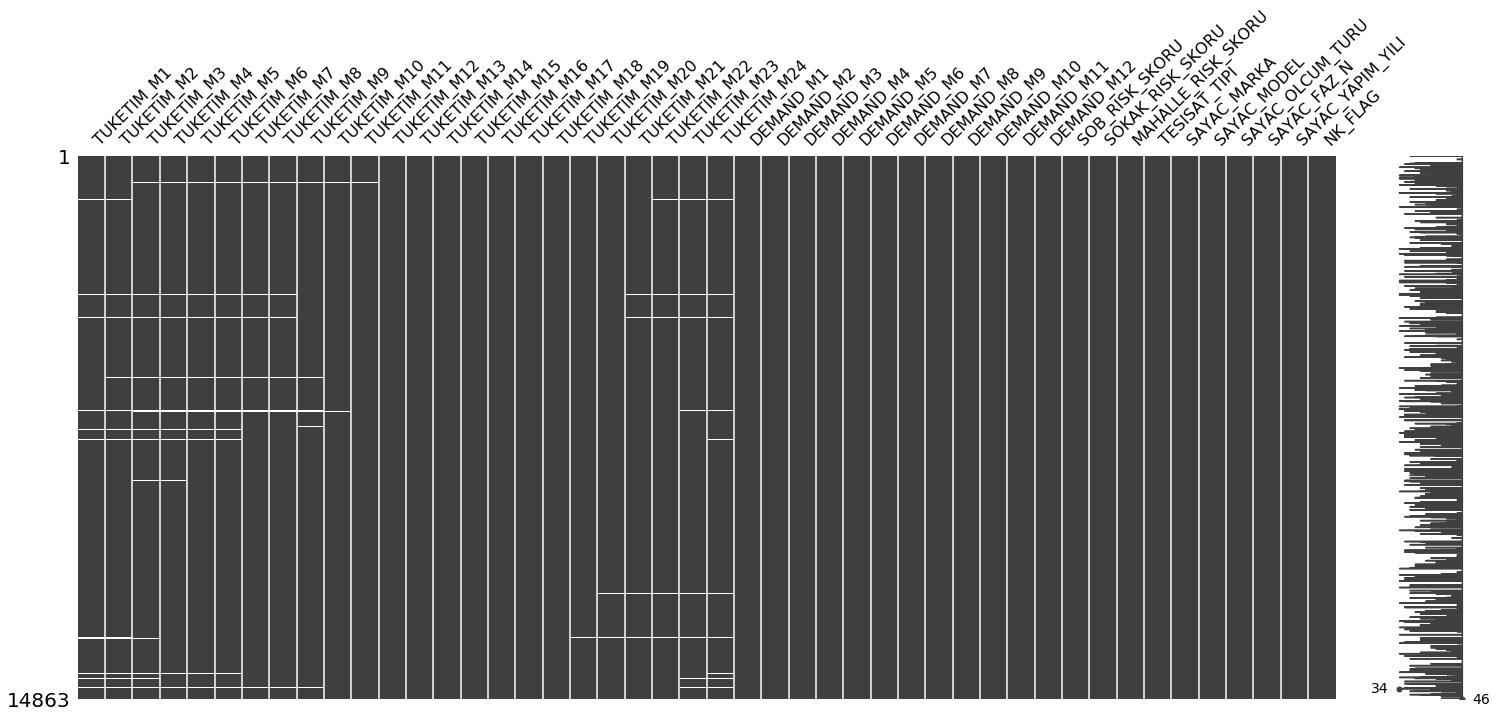

In [425]:
#İlgili sütunların NaN değişkenlerinin MISSING ve 9999 değerleri ile doldurulması
processed_table_v1['SAYAC_MODEL'] = processed_table_v1['SAYAC_MODEL'].fillna('MISSING')
processed_table_v1['SAYAC_MARKA'] = processed_table_v1['SAYAC_MARKA'].fillna('MISSING')
processed_table_v1['SAYAC_YAPIM_YILI'] = processed_table_v1['SAYAC_YAPIM_YILI'].fillna(9999)

#Eksik değer grafiği
msno.matrix(processed_table_v1)

<h3>Gruplamalar</h3>

In [426]:
for marka in processed_table_v1['SAYAC_MARKA']:
  if (marka == 'ALFATECH') | (marka == 'DMA') | (marka == 'KAAN') | (marka == 'NORA'):
    processed_table_v1['SAYAC_MARKA'] = processed_table_v1['SAYAC_MARKA'].str.replace(marka, 'other')
  if (marka == 'KOHLER') | (marka == 'MAKEL') | (marka == 'VI-KO'):
    processed_table_v1['SAYAC_MARKA'] = processed_table_v1['SAYAC_MARKA'].str.replace(marka, 'KMV')

processed_table_v1['SAYAC_MARKA'].value_counts()

LUNA          6510
ELEKTROMED    5493
KMV           2735
other           75
MISSING         50
Name: SAYAC_MARKA, dtype: int64

In [427]:
sayac_model_processed_table = processed_table_v1[['SAYAC_MODEL','NK_FLAG']]

dict1 = sayac_model_processed_table.SAYAC_MODEL.value_counts().to_dict()

for key,value in dict1.items():
    if value < 500:
        sayac_model_processed_table.SAYAC_MODEL = sayac_model_processed_table.SAYAC_MODEL.str.replace(rf'^{key}$', 'mini_other', regex = True)
    elif value >= 500 and value < 1000:
        sayac_model_processed_table.SAYAC_MODEL = sayac_model_processed_table.SAYAC_MODEL.str.replace(rf'^{key}$', 'other', regex = True)
    else:
        continue

processed_table_v1.SAYAC_MODEL = sayac_model_processed_table.SAYAC_MODEL

In [428]:
risk_and_msrt = processed_table_v1[(processed_table_v1['SOKAK_RISK_SKORU'] > processed_table_v1['MAHALLE_RISK_SKORU']) &
                                (processed_table_v1['SAYAC_OLCUM_TURU'] == 'Kombi')]
index_risk_msrt = risk_and_msrt.index.tolist()
processed_table_v1['RISK_VE_OLCUM'] = 0
processed_table_v1.loc[index_risk_msrt, 'RISK_VE_OLCUM'] = 1
processed_table_v1['RISK_VE_OLCUM'].value_counts()

0    14837
1       26
Name: RISK_VE_OLCUM, dtype: int64

In [429]:
processed_table_v2 = processed_table_v1.copy()
processed_table_v2.reset_index(drop=True, inplace=True)

In [431]:
product_year = processed_table_v2['SAYAC_YAPIM_YILI'].value_counts().to_dict()
product_year_list = []
for i in range(len(processed_table_v2['SAYAC_YAPIM_YILI'])):
    value = product_year[processed_table_v2['SAYAC_YAPIM_YILI'][i]]
    if value < 1000:
        processed_table_v2.loc[i, 'SAYAC_YAPIM_YILI'] = 0
    elif value < 2000:
        processed_table_v2.loc[i, 'SAYAC_YAPIM_YILI'] = 1
    elif value < 3000:
        processed_table_v2.loc[i, 'SAYAC_YAPIM_YILI'] = 2
    else:
        processed_table_v2.loc[i, 'SAYAC_YAPIM_YILI'] = 3

processed_table_v2['SAYAC_YAPIM_YILI']

0        1.0
1        1.0
2        3.0
3        3.0
4        2.0
        ... 
14858    3.0
14859    1.0
14860    1.0
14861    1.0
14862    1.0
Name: SAYAC_YAPIM_YILI, Length: 14863, dtype: float64

In [433]:
index = []
for i in range(processed_table_v2.shape[0]):
    for j in range(24):

        Q1 = np.quantile(processed_table_v2.iloc[:,j], 0.25)
        Q3 = np.quantile(processed_table_v2.iloc[:,j], 0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5*IQR
        upper_bound = Q3 + 1.5*IQR

        if ((processed_table_v2.iloc[i,j] < lower_bound) | (processed_table_v2.iloc[i,j] > upper_bound)):
            index.append(i)

TypeError: 'DataFrame' object is not callable

In [445]:
outliers = set(index)

{4099,
 5,
 6150,
 10249,
 14348,
 13,
 14350,
 4113,
 4115,
 8211,
 12307,
 10267,
 14363,
 12318,
 2080,
 6176,
 8226,
 8227,
 4132,
 14373,
 12326,
 2087,
 4137,
 6185,
 14386,
 51,
 2099,
 61,
 63,
 64,
 8257,
 2114,
 8262,
 10311,
 4170,
 2123,
 8268,
 6221,
 4176,
 6225,
 4181,
 6231,
 4185,
 10330,
 4188,
 12380,
 8287,
 14431,
 97,
 98,
 2147,
 6241,
 6242,
 107,
 12395,
 111,
 12399,
 12405,
 8311,
 4216,
 4219,
 8316,
 14460,
 10366,
 6271,
 128,
 6272,
 8321,
 8323,
 2180,
 8324,
 6278,
 135,
 6279,
 12416,
 2186,
 6283,
 8330,
 8332,
 10378,
 14471,
 8340,
 6301,
 10398,
 10399,
 161,
 4257,
 8354,
 10403,
 12453,
 2216,
 10408,
 6315,
 6316,
 2222,
 2224,
 8369,
 10416,
 4275,
 10420,
 8373,
 14513,
 10424,
 185,
 10426,
 14520,
 14522,
 2238,
 4289,
 195,
 14531,
 2246,
 199,
 2248,
 10440,
 2252,
 12493,
 8399,
 208,
 12496,
 2258,
 211,
 4308,
 213,
 2262,
 215,
 4309,
 8403,
 4314,
 12504,
 10460,
 14554,
 8415,
 2273,
 6371,
 4324,
 8420,
 12516,
 6376,
 4329,
 14570,

In [447]:
tuketim_outlier = processed_table_v2.loc[outliers, :]
tuketim_outlier['NK_FLAG'].value_counts()

0    959
1    126
Name: NK_FLAG, dtype: int64

In [448]:
index_outlier = tuketim_outlier.index.to_list()
processed_table_v2['TUKETIM_OUTLIER'] = 0
processed_table_v2.loc[index_outlier, 'TUKETIM_OUTLIER'] = 1

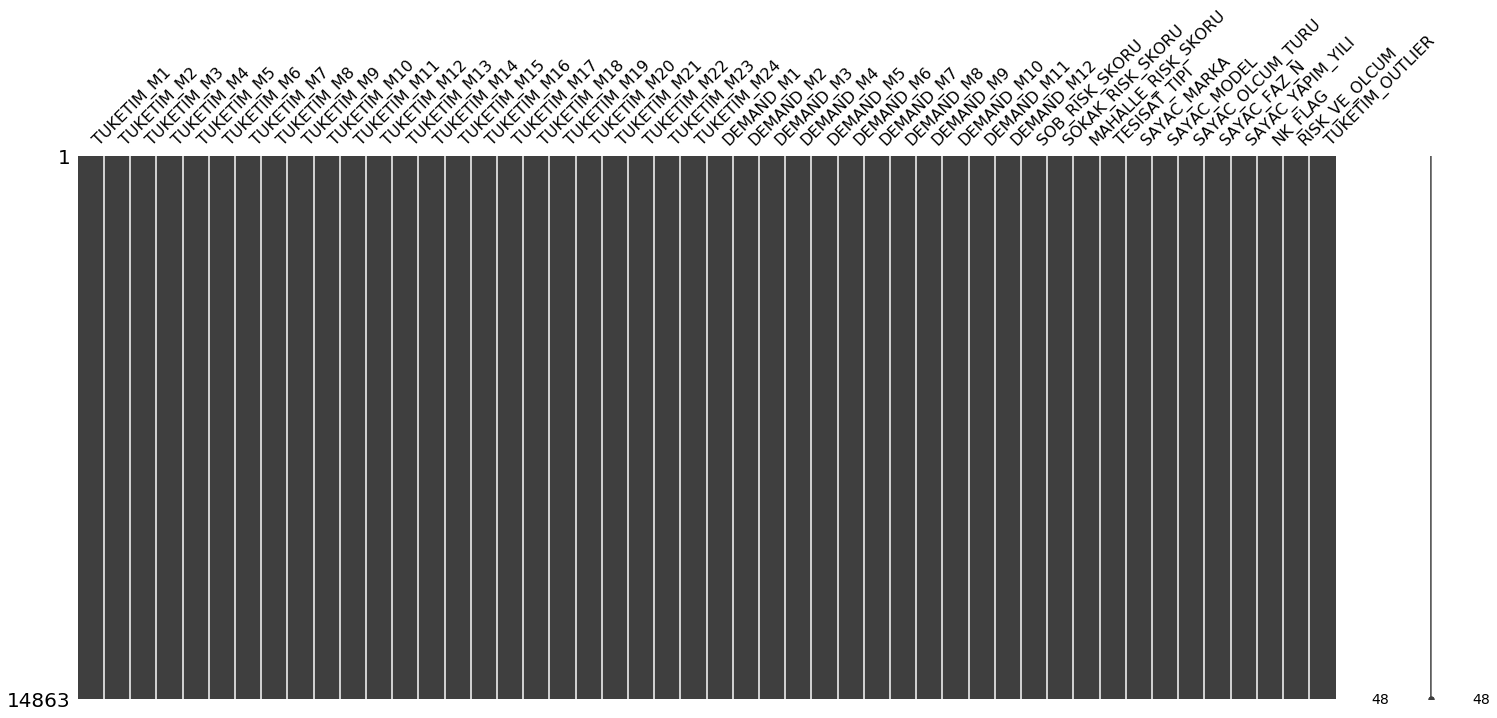

In [449]:
processed_table_v2.iloc[:,:24] = processed_table_v2.iloc[:, :24].fillna(processed_table_v2.iloc[:,:24].mean())
msno.matrix(processed_table_v2)

In [454]:
data_for_split = processed_table_v2.copy()
data_for_split.iloc[:,39:]

,TESISAT_TIPI,SAYAC_MARKA,SAYAC_MODEL,SAYAC_OLCUM_TURU,SAYAC_FAZ_N,SAYAC_YAPIM_YILI,NK_FLAG,RISK_VE_OLCUM,TUKETIM_OUTLIER
0,Mesken,LUNA,LUN1,Aktif,Monofaze,1.0,0,0,0
1,Mesken,ELEKTROMED,EC058MBW,Aktif,Monofaze,1.0,0,0,0
2,Mesken,ELEKTROMED,mini_other,Aktif,Trifaze,3.0,0,0,0
3,Ticarethane-Sanayi,LUNA,LUN10,Aktif,Monofaze,3.0,0,0,0
4,Mesken,LUNA,LUN10-B,Aktif,Monofaze,2.0,0,0,0
...,...,...,...,...,...,...,...,...,...
14858,Mesken,LUNA,LUN10,Aktif,Monofaze,3.0,0,0,0
14859,Mesken,ELEKTROMED,EC058MBW,Aktif,Monofaze,1.0,0,0,0
14860,Mesken,LUNA,LUN1,Aktif,Monofaze,1.0,0,0,0
14861,Mesken,KMV,mini_other,Aktif,Monofaze,1.0,0,0,0


In [455]:
data_for_split['TESISAT_TIPI'].replace({'Mesken':1, 'Ticarethane-Sanayi':0}, inplace=True)
data_for_split['SAYAC_OLCUM_TURU'].replace({'Aktif':1, 'Kombi':0}, inplace=True)
data_for_split['SAYAC_FAZ_N'].replace({'Monofaze':1, 'Trifaze':0}, inplace=True)

<h4>Validation Setinin Ayrılması</h4>


In [476]:
flag_one = data_for_split[data_for_split['NK_FLAG'] == 1]
flag_two = data_for_split[data_for_split['NK_FLAG'] == 0]

flag_one = flag_one.iloc[90:300,:]
flag_two = flag_two.iloc[600:3390,:]
frames = [flag_one, flag_two]
val_data = pd.concat(frames)
index_val = val_data.index.to_list()
data_for_encoding = data_for_split.drop(index_val)

In [477]:
val_data.to_csv('validation-data-v1.csv')

<h3>ONE-HOT ENCODING</h3>

In [478]:
from sklearn.preprocessing import OneHotEncoder

In [479]:
data_for_encoding_v1 = data_for_encoding.copy()

In [480]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc_fit = enc.fit(data_for_encoding_v1[['SAYAC_MARKA','SAYAC_MODEL']])
enc_fit_df = pd.DataFrame(enc_fit.fit_transform(data_for_encoding_v1[['SAYAC_MARKA','SAYAC_MODEL']]))

In [481]:
data_for_encoding_v1.drop(columns=['SAYAC_MARKA','SAYAC_MODEL'], inplace=True)
data_for_encoding_v1.reset_index(drop=True, inplace=True)

In [482]:
encoded_data = data_for_encoding_v1.join(enc_fit_df)

In [486]:
encoded_data.to_csv('encoded-data-v1.csv')

In [ ]:
# index = []
# for i in range(for_one_flag.shape[0]):
#     for j in range(24):
#         if for_one_flag.iloc[i,j] == 0:
#             index.append(i)

In [ ]:
# mylist2 = list(dict.fromkeys(index))
# tuketim_zero = for_one_flag.iloc[mylist2, :]
# tuketim_zero['NK_FLAG'].value_counts()

In [ ]:
# a=list(set(index))
# a.sort()
# upper_year = []
# lower_year = []
# for i in range(len(a)):
#     if index.count(a[i]) > 12:
#         upper_year.append(a[i])
#     if index.count(a[i]) <= 12:
#         lower_year.append(a[i])

# upper_year_pd = for_one_flag.iloc[upper_year, :]
# lower_year_pd = for_one_flag.iloc[lower_year, :]